# Nerual Network Classification with PyTorch


In [1]:
import torch
import sklearn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'2.1.0+cu118'

## Make Classification data and get it ready

In [3]:
from sklearn.datasets import make_circles

# Make a 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.02,
                    random_state=42)

In [4]:
X.shape, y.shape

((1000, 2), (1000,))

In [5]:
X[:5]

array([[ 0.76026594,  0.22387823],
       [-0.76722217,  0.1455425 ],
       [-0.80815854,  0.14894355],
       [-0.3760283 ,  0.70320906],
       [ 0.44051035, -0.89761737]])

In [6]:
y[:5]

array([1, 1, 1, 1, 0])

In [7]:
# Make a DataFrame of circle dataset
import pandas as pd
circles_df = pd.DataFrame({'X1': X[:, 0],
                           'X2': X[:, 1],
                           'y': y})
circles_df.head(10)

,X1,X2,y
0,0.760266,0.223878,1
1,-0.767222,0.145542,1
2,-0.808159,0.148944,1
3,-0.376028,0.703209,1
4,0.440510,-0.897617,0
5,-0.484527,0.660633,1
6,-0.012450,0.802211,1
7,0.777458,0.141876,1
8,-0.166138,-0.790265,1
9,-0.126921,1.011160,0


### Visualize our data using matplotlib.pyplot

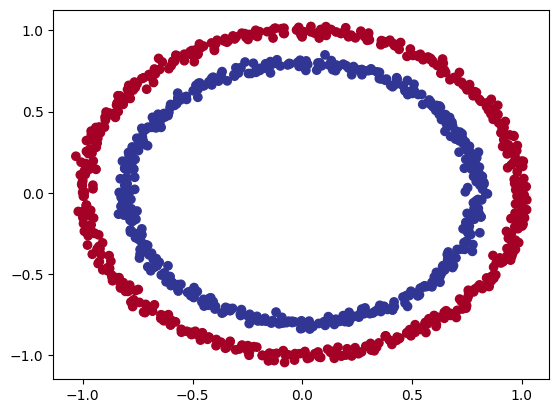

In [8]:
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)



**Note**: The Data we're working with is often referred to as a `toy dataset` that is small enough to experiment but still sizable to practice the fundamentals



In [9]:
X = torch.from_numpy(circles_df.drop(['y'], axis=1).to_numpy()).type(torch.float)
y = torch.from_numpy(circles_df['y'].to_numpy()).type(torch.float)

In [10]:
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [11]:
type(X), X.dtype, type(y), y.dtype

(torch.Tensor, torch.float32, torch.Tensor, torch.float32)

In [12]:
X[1], y[1]

(tensor([-0.7672,  0.1455]), tensor(1.))

### Splitting data into Train and Test sets

In [13]:
# set seed for reproducibility
torch.manual_seed(42)

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

## Building a PyTorch model

Let's build a model to classify our blue and red dots

We want to:
1. **Set up device agnostic code**: so our code will run with an acclerator (GPU), if there is one
2. **Construct a model**: subclass `nn.Module`
3. **Define Loss & Optimizer**: `BCELossWithLogits` and optimizer `Adam`
4. **Building Training Loop**

In [15]:
import torch
from torch import nn

# make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Create our PyTorch Model architecture
* Subclassing `nn.Module()`
* Create **`2 nn.Linear()`**  that are capable of exracting patterns from data, and apply those with good accuracy
* Define a **`forward() method`** that does `Forward Propagation` (process of flowing of data through neural network)
* Create an instance of this model constuctor, and set it to target device

In [16]:
# 1. Construct our model
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # make 2 nn.Linear layers
    self.linear_layer = nn.Linear(in_features=2, out_features=8)
    self.output = nn.Linear(in_features=8, out_features=1)

  def forward(self, X:torch.Tensor) -> torch.Tensor:
    return self.output(self.linear_layer(X))


model_0 = CircleModelV0()
model_0

CircleModelV0(
  (linear_layer): Linear(in_features=2, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=1, bias=True)
)

In [17]:
print(f'Our Model is currently default to device: {next(model_0.parameters()).device}')

Our Model is currently default to device: cpu


In [18]:
model_0.to(device)
print(f'Our Model is currently default to device: {next(model_0.parameters()).device}')

Our Model is currently default to device: cuda:0


### Re-creating our simple PyTorch model using **nn.Sequential**

See, writing our code using `nn.Sequential()` was really easy, and could be a preferrable way to go to, while building PyTorch Models

But...

When we build complex Deep PyTorch models, it will be really much better if we use our own forward pass method, therefore `nn.Sequential()` can be used with building / training small models.

> **We could also use `nn.Sequential` inside our `nn.Module` class**

```
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # make 2 nn.Linear layers
    self.seq1 = nn.Sequential(
      nn.Linear(in_features=2,out_features=8),
      nn.Linear(in_features=8, out_features=1)).to(device)

  def forward(self, X:torch.Tensor) -> torch.Tensor:
    return self.seq1(X)

```

In [19]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.Linear(in_features=8, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

In [20]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.1177, -0.2296],
                      [ 0.4370,  0.1102],
                      [ 0.5713,  0.0773],
                      [-0.2230,  0.1900],
                      [-0.1918,  0.2976],
                      [ 0.6313,  0.4087],
                      [-0.3091,  0.4082],
                      [ 0.1265,  0.3591]], device='cuda:0')),
             ('0.bias',
              tensor([-0.4310, -0.7000, -0.2732, -0.5424,  0.5802,  0.2037,  0.2929,  0.2236],
                     device='cuda:0')),
             ('1.weight',
              tensor([[-0.0062,  0.2767, -0.2512,  0.0223, -0.2413,  0.1090, -0.1218,  0.1083]],
                     device='cuda:0')),
             ('1.bias', tensor([-0.0737], device='cuda:0'))])

### Make Predictions using untrained PyTorch model

In [21]:
# make predictions!
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
  print(f'Shape of predictions: {untrained_preds.shape}')

Shape of predictions: torch.Size([200, 1])


In [22]:
untrained_preds[:10]

tensor([[-0.4047],
        [-0.3590],
        [-0.4288],
        [-0.3994],
        [-0.2652],
        [-0.2390],
        [-0.2325],
        [-0.2038],
        [-0.4360],
        [-0.3505]], device='cuda:0')

In [23]:
y_test[:10]

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])

## Training our simple PyTorch model

* Set up loss and optimizer
* Create a Train loop

> Loss Functions:
Since we are in a Binary Classification Project, based on the availability of loss functions in PyTorch, we can choose:
* `nn.BCELoss()`: requries data to have gone through a sigmoid activation function in the output layer of the model
* `nn.BCEWithLogitsLoss()`: sigmoid activation function is built in!

**Since we have built a PyTorch model with `nn.Linear`, therefore by a linear activation, we will use nn.BCEWithLogitsLoss()**

In [24]:
# set up loss function
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                             lr=0.1)

In [25]:
# Calculate accuracy - out of 100 how many correct ones did our model get
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct/len(y_pred) * 100
  return acc

### Going from logits -> probablilties -> prediction labels

* **Logits:** Raw output of our model, without have gone through the activation function

* **Probablities:** output of when the logits go through a activation function like `Sigmoid` or `Softmax`, they are probabilities of each class

* **Prediction Labels**: Rounding off or finding the Positional Max, helps us find which class does the input data belong to!

In [26]:
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))
y_logits[:5]

tensor([[-0.4047],
        [-0.3590],
        [-0.4288],
        [-0.3994],
        [-0.2652]], device='cuda:0')

In [27]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [28]:
# use sigmoid activation function on our logits to turn them into prediction probabilities!
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs[:5]

tensor([[0.4002],
        [0.4112],
        [0.3944],
        [0.4015],
        [0.4341]], device='cuda:0')

In [29]:
y_preds = torch.round(y_pred_probs)
y_preds[:5]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [30]:
# Everything all together
with torch.inference_mode():
  y_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)))).squeeze()
print(torch.eq(y_test.to(device), y_labels).sum().item())
y_labels[:5], y_labels.shape

100


(tensor([0., 0., 0., 0., 0.], device='cuda:0'), torch.Size([200]))

### Build Train and Test loop


In [31]:
# Training Loop
EPOCHS = 100

# Tracking loss and epochs
epoch_list = []
train_loss_val, test_loss_val = [], []

for epoch in range(EPOCHS):
  # set model to train mode
  model_0.train()

  # Forward Propagation
  y_logits = model_0(X_train.to(device)).squeeze()

  # Calculate the loss and accuracy
  train_loss = loss_fn(y_logits, y_train.to(device))

  y_preds = torch.round(torch.sigmoid(y_logits))
  train_acc = accuracy_fn(y_train.to(device), y_preds)

  optimizer.zero_grad()
  # Backpropagation
  train_loss.backward()
  # Gradient Descent - update all trainable parameters
  optimizer.step()

  # Making predictions on the test data
  model_0.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_0(X_test.to(device)).squeeze()
    # Calculate loss and accuracy
    test_loss = loss_fn(test_logits, y_test.to(device))
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_acc = accuracy_fn(y_test.to(device), test_preds)

  # update loss tracking variables
  epoch_list.append(epoch)
  train_loss_val.append(train_loss)
  test_loss_val.append(test_loss)

  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}')

Epoch: 0 | Train Loss: 0.70806 | Train Accuracy: 50.00 | Test Loss: 0.70729 | Test Accuracy: 50.00
Epoch: 10 | Train Loss: 0.69665 | Train Accuracy: 50.00 | Test Loss: 0.69751 | Test Accuracy: 50.00
Epoch: 20 | Train Loss: 0.69393 | Train Accuracy: 45.38 | Test Loss: 0.69524 | Test Accuracy: 42.00
Epoch: 30 | Train Loss: 0.69327 | Train Accuracy: 47.25 | Test Loss: 0.69471 | Test Accuracy: 48.50
Epoch: 40 | Train Loss: 0.69310 | Train Accuracy: 49.38 | Test Loss: 0.69458 | Test Accuracy: 49.00
Epoch: 50 | Train Loss: 0.69305 | Train Accuracy: 50.12 | Test Loss: 0.69454 | Test Accuracy: 47.50
Epoch: 60 | Train Loss: 0.69303 | Train Accuracy: 50.50 | Test Loss: 0.69453 | Test Accuracy: 47.50
Epoch: 70 | Train Loss: 0.69302 | Train Accuracy: 50.88 | Test Loss: 0.69452 | Test Accuracy: 47.00
Epoch: 80 | Train Loss: 0.69302 | Train Accuracy: 50.62 | Test Loss: 0.69451 | Test Accuracy: 47.50
Epoch: 90 | Train Loss: 0.69301 | Train Accuracy: 50.88 | Test Loss: 0.69451 | Test Accuracy: 47.50


## Make Predictions and evaluate the model

From the metrics, it looks like our model isn't training anything.. !

So, let's make some predictions and visualize our dataset

**To do so, we're going to import a function called** `plot_decision_boundry()`

In [32]:
import requests
from pathlib import Path

# download helper functions from learn-pytorch repo
if Path('helper_functions.py').is_file():
  print('File exists!!')
else:
  print('Downloading helper functions!')
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

In [33]:
from helper_functions import plot_predictions, plot_decision_boundary

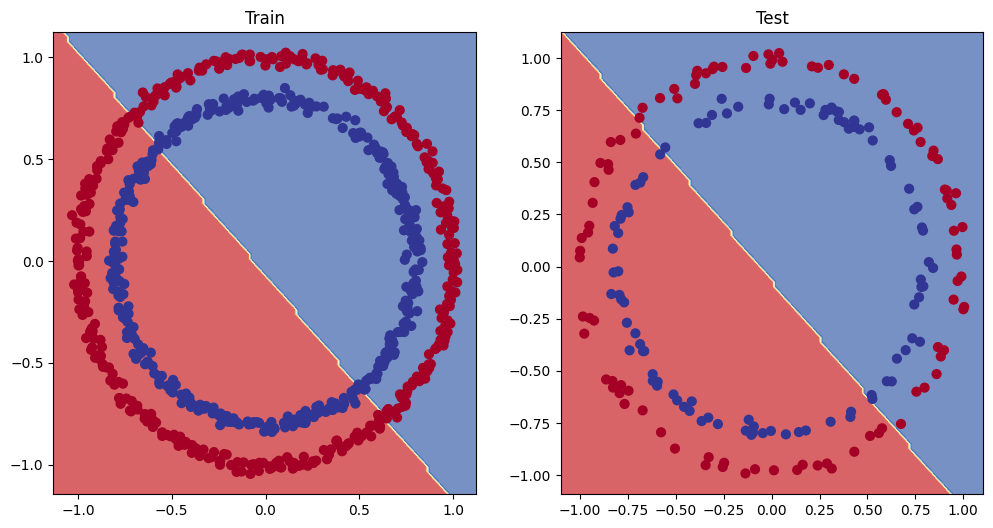

In [34]:
# plot decision boundary of model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

## Improving our Model

* Add more Hidden layers
* Add more hiddens neurons/nodes in each layer
* Fit for longer
* Changing the Activation
* Changing the loss function

In [35]:
# let's build a better model
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    # make more layers with more hidden units
    self.seq_layer_block = nn.Sequential(
        nn.Linear(in_features=2, out_features=100),
        nn.Linear(in_features=100, out_features=100),
        nn.Linear(in_features=100, out_features=1)
    )

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.seq_layer_block(x)

model_1 = CircleModelV1().to(device)

In [36]:
next(model_1.parameters()).device

device(type='cuda', index=0)

In [37]:
# loss function
loss_fn = torch.nn.BCEWithLogitsLoss()
# create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [38]:
EPOCHS = 1000

for epoch in range(EPOCHS):
  model_1.train()

  y_logits = model_1(X_train.to(device)).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  train_loss = loss_fn(y_logits, y_train.to(device))
  train_acc = accuracy_fn(y_train.to(device), y_preds)

  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test.to(device)).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test.to(device))
    test_acc = accuracy_fn(y_test.to(device), test_preds)

    if epoch % 100 == 0:
      print(f'Epoch: {epoch} | Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}')

Epoch: 0 | Train Loss: 0.69446 | Train Accuracy: 41.50 | Test Loss: 0.69667 | Test Accuracy: 48.00
Epoch: 100 | Train Loss: 0.69298 | Train Accuracy: 51.25 | Test Loss: 0.69469 | Test Accuracy: 45.50
Epoch: 200 | Train Loss: 0.69298 | Train Accuracy: 51.25 | Test Loss: 0.69469 | Test Accuracy: 45.50
Epoch: 300 | Train Loss: 0.69298 | Train Accuracy: 51.25 | Test Loss: 0.69469 | Test Accuracy: 45.50
Epoch: 400 | Train Loss: 0.69298 | Train Accuracy: 51.25 | Test Loss: 0.69469 | Test Accuracy: 45.50
Epoch: 500 | Train Loss: 0.69298 | Train Accuracy: 51.25 | Test Loss: 0.69469 | Test Accuracy: 45.50
Epoch: 600 | Train Loss: 0.69298 | Train Accuracy: 51.25 | Test Loss: 0.69469 | Test Accuracy: 45.50
Epoch: 700 | Train Loss: 0.69298 | Train Accuracy: 51.25 | Test Loss: 0.69469 | Test Accuracy: 45.50
Epoch: 800 | Train Loss: 0.69298 | Train Accuracy: 51.25 | Test Loss: 0.69469 | Test Accuracy: 45.50
Epoch: 900 | Train Loss: 0.69298 | Train Accuracy: 51.25 | Test Loss: 0.69469 | Test Accuracy

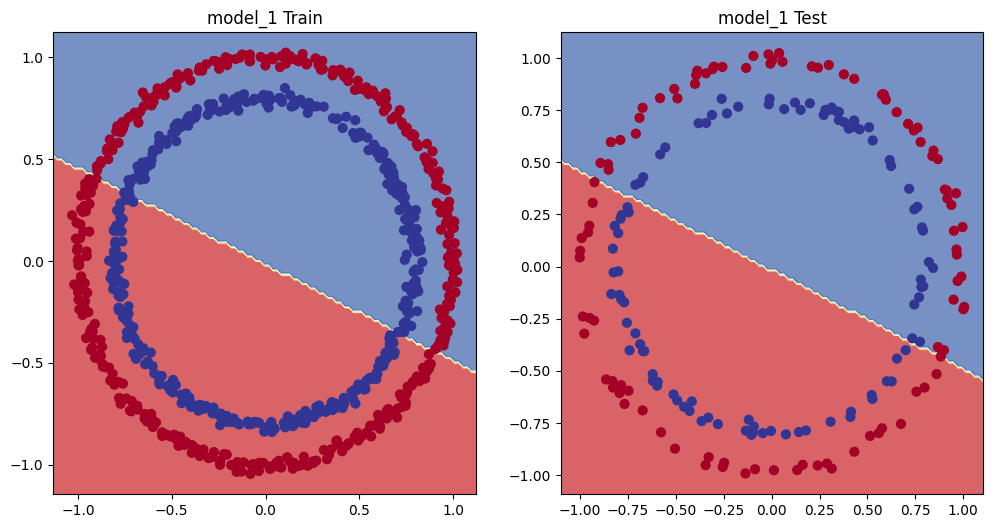

In [39]:
# plot decision boundary of model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('model_1 Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('model_1 Test')
plot_decision_boundary(model_1, X_test, y_test)

## Preparing our data to see if our model can fit a straight line

In [40]:
weight = 0.7
bias = 0.3

START = 0
END = 1
STEP = 0.01

X_reg = torch.arange(START, END, STEP).unsqueeze(dim=1)
y_reg = weight * X_reg + bias

In [41]:
X_reg[:5], y_reg[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [42]:
X_reg.shape, y_reg.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

In [43]:
train_size = int(len(X_reg)*0.8)
X_train_reg, y_train_reg = X_reg[:train_size], y_reg[:train_size]
X_test_reg, y_test_reg = X_reg[train_size:], y_reg[train_size:]

In [44]:
X_train_reg.shape, y_test_reg.shape, X_test_reg.shape, y_test_reg.shape

(torch.Size([80, 1]),
 torch.Size([20, 1]),
 torch.Size([20, 1]),
 torch.Size([20, 1]))

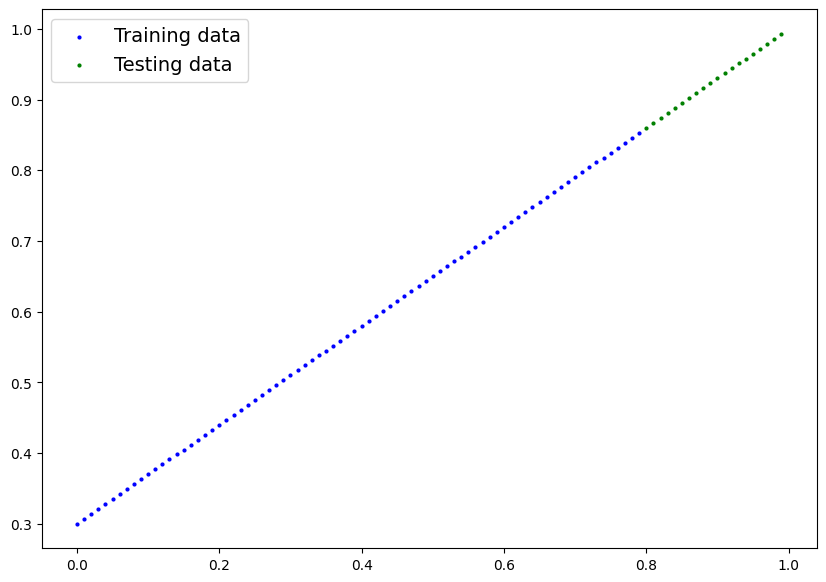

In [45]:
plot_predictions(train_data=X_train_reg, train_labels=y_train_reg,
                 test_data=X_test_reg, test_labels=y_test_reg)

In [46]:
linear_model = nn.Sequential(
    nn.Linear(in_features=1, out_features=100),
    nn.Linear(in_features=100, out_features=100),
    nn.Linear(in_features=100, out_features=1),
).to(device)

In [47]:
reg_loss_fn = torch.nn.L1Loss()
reg_optimizer = torch.optim.SGD(params=linear_model.parameters(),
                                lr=0.1)

In [48]:
EPOCHS = 1000
X_train_reg, y_train_reg, = X_train_reg.to(device), y_train_reg.to(device)
X_test_reg, y_test_reg = X_test_reg.to(device), y_test_reg.to(device)

for epoch in range(EPOCHS):
  linear_model.train()
  y_preds = linear_model(X_train_reg)

  train_loss = reg_loss_fn(y_train_reg, y_preds)

  reg_optimizer.zero_grad()
  train_loss.backward()
  reg_optimizer.step()

  linear_model.eval()
  with torch.inference_mode():
    test_preds = linear_model(X_test_reg)
    test_loss = reg_loss_fn(y_test_reg, test_preds)

  if epoch % 100 == 0:
    print(f'Epoch: {epoch} | Train MAE/Loss: {train_loss:.5f} | Test MAE/Loss: {test_loss:.5f}')

Epoch: 0 | Train MAE/Loss: 0.39954 | Test MAE/Loss: 2.52283
Epoch: 100 | Train MAE/Loss: 0.06854 | Test MAE/Loss: 0.18034
Epoch: 200 | Train MAE/Loss: 0.07337 | Test MAE/Loss: 0.05576
Epoch: 300 | Train MAE/Loss: 0.13458 | Test MAE/Loss: 0.02360
Epoch: 400 | Train MAE/Loss: 0.05995 | Test MAE/Loss: 0.03970
Epoch: 500 | Train MAE/Loss: 0.04537 | Test MAE/Loss: 0.04993
Epoch: 600 | Train MAE/Loss: 0.02576 | Test MAE/Loss: 0.10706
Epoch: 700 | Train MAE/Loss: 0.06139 | Test MAE/Loss: 0.04088
Epoch: 800 | Train MAE/Loss: 0.06494 | Test MAE/Loss: 0.16901
Epoch: 900 | Train MAE/Loss: 0.14303 | Test MAE/Loss: 0.11010


In [49]:
with torch.inference_mode():
  reg_y_preds = linear_model(X_test_reg)
reg_y_preds[:5], reg_y_preds.shape

(tensor([[0.8914],
         [0.8971],
         [0.9028],
         [0.9085],
         [0.9142]], device='cuda:0'),
 torch.Size([20, 1]))

In [50]:
print(f'Test Loss: {reg_loss_fn(y_test_reg, reg_y_preds):.5f}')

Test Loss: 0.01896


<Figure size 400x800 with 0 Axes>

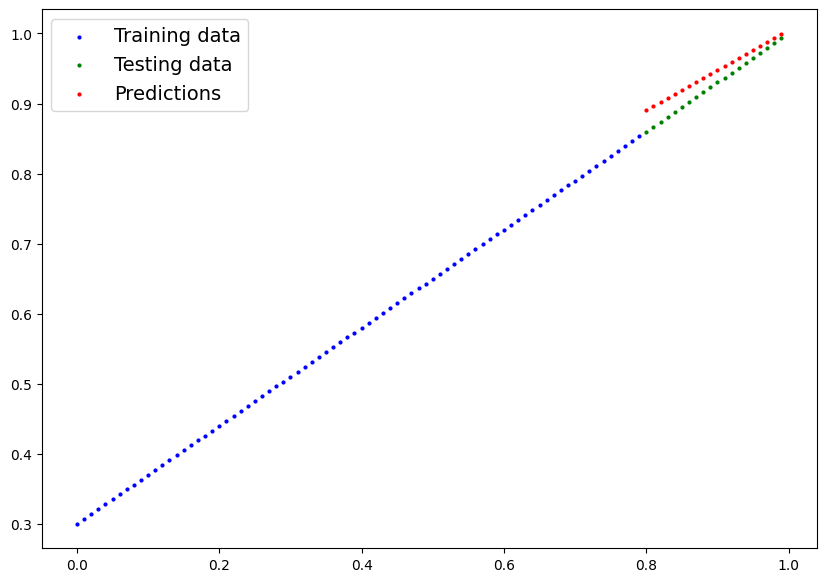

In [51]:
plt.figure(figsize=(4, 8))
plot_predictions(train_data=X_train_reg.cpu(), train_labels=y_train_reg.cpu(),
                 test_data=X_test_reg.cpu(), test_labels=y_test_reg.cpu(),
                 predictions=reg_y_preds.cpu())

Our Model indeed fits a straight line almost perfectly, but, it can't classify a bunch of points in the shape of circles, why is that so ?? 🤔

Just Imagine, you were given points to classify as  circle (toy dataset), and you can just draw a straight line to classigfy them, the best line anyone could recive is a 50-50% predicting accuracy!

Imagine the same dataset, but now you have the freedom to make non-linear lines (non-straight), so will it not be easy?

**We must need something called Non-Linearity in our model, so that our model can draw a non-linear line with respect to the dataset, these non-linearity comes in terms of Non-linear Activations!! 😀**

## The missing piece: Non-Linearity

### Recreating non-linear data (red and blue circles)

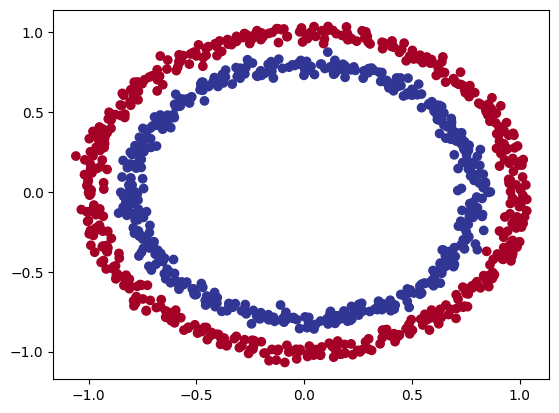

In [52]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples=1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

### Convert our data to tensors and split into Training and Testing sets

In [53]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [54]:
X

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        ...,
        [-0.1369, -0.8100],
        [ 0.6704, -0.7675],
        [ 0.2811,  0.9638]])

In [55]:
y[:5]

tensor([1., 1., 1., 1., 0.])

In [56]:
from sklearn.model_selection import train_test_split
train_size = int(len(X)*0.8)
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2,
                                                     random_state=42)

In [57]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

### Building a model with non-linearity!!

In [58]:
from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # creating layers with non-linear activations
    self.linear_layer1 = nn.Linear(in_features=2, out_features=64)
    self.linear_layer2 = nn.Linear(in_features=64, out_features=32)
    self.linear_layer3 = nn.Linear(in_features=32, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, X:torch.Tensor) -> torch.Tensor:
    return self.linear_layer3(self.relu(self.linear_layer2(self.relu(self.linear_layer1(X)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (linear_layer1): Linear(in_features=2, out_features=64, bias=True)
  (linear_layer2): Linear(in_features=64, out_features=32, bias=True)
  (linear_layer3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [59]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                   lr=0.1)

### Training a Non-linear Model!!

In [60]:
EPOCHS = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(EPOCHS):
  model_3.train()

  train_logits = model_3(X_train).squeeze()
  train_preds = torch.round(torch.sigmoid(train_logits))

  train_loss = loss_fn(train_logits, y_train)
  train_acc = accuracy_fn(y_train, train_preds)

  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_preds)


  if epoch % 100 == 0:
    print(f'Epoch: {epoch} | Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}')


Epoch: 0 | Train Loss: 0.69430 | Train Accuracy: 49.88 | Test Loss: 0.69637 | Test Accuracy: 47.50
Epoch: 100 | Train Loss: 0.68161 | Train Accuracy: 64.00 | Test Loss: 0.68389 | Test Accuracy: 60.50
Epoch: 200 | Train Loss: 0.66187 | Train Accuracy: 89.62 | Test Loss: 0.66647 | Test Accuracy: 83.00
Epoch: 300 | Train Loss: 0.61536 | Train Accuracy: 98.50 | Test Loss: 0.62588 | Test Accuracy: 95.50
Epoch: 400 | Train Loss: 0.51072 | Train Accuracy: 99.62 | Test Loss: 0.52996 | Test Accuracy: 98.50
Epoch: 500 | Train Loss: 0.33504 | Train Accuracy: 100.00 | Test Loss: 0.36436 | Test Accuracy: 99.50
Epoch: 600 | Train Loss: 0.22592 | Train Accuracy: 99.12 | Test Loss: 0.25624 | Test Accuracy: 96.50
Epoch: 700 | Train Loss: 0.10530 | Train Accuracy: 100.00 | Test Loss: 0.13834 | Test Accuracy: 100.00
Epoch: 800 | Train Loss: 0.06496 | Train Accuracy: 100.00 | Test Loss: 0.09422 | Test Accuracy: 100.00
Epoch: 900 | Train Loss: 0.04496 | Train Accuracy: 100.00 | Test Loss: 0.07082 | Test Ac

In [61]:
with torch.inference_mode():
  y_logits = model_3(X_test).squeeze()
y_logits[:5]

tensor([ 5.1569, -2.7489,  4.9185, -4.6463,  2.0941], device='cuda:0')

In [62]:
print(f'Test Loss: {loss_fn(y_logits, y_test)}')
print(f'Test Accuracy: {accuracy_fn(y_test, torch.round(torch.sigmoid(y_logits)))}%')

Test Loss: 0.056861236691474915
Test Accuracy: 100.0%


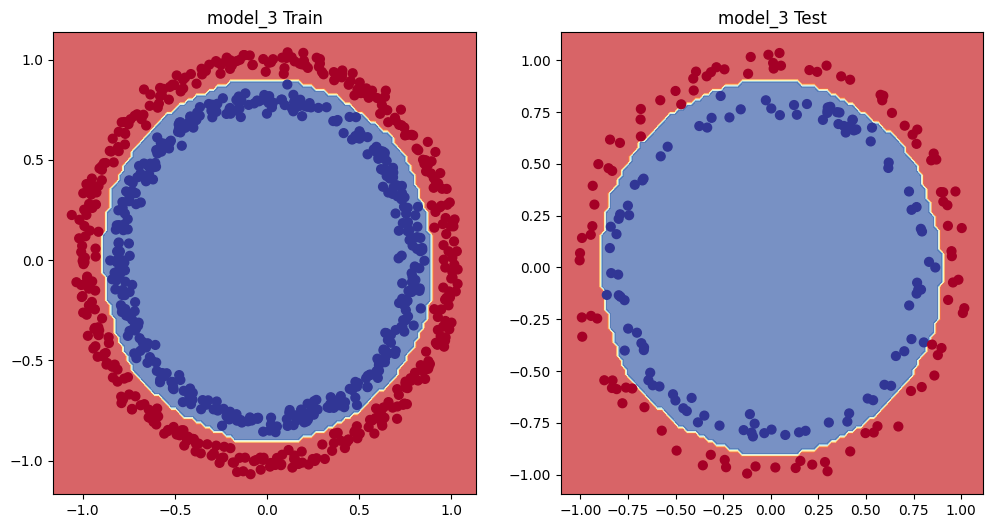

In [63]:
# plot decision boundary of model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('model_3 Train')
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('model_3 Test')
plot_decision_boundary(model_3, X_test, y_test)

In [64]:
model_3.state_dict()

OrderedDict([('linear_layer1.weight',
              tensor([[ 0.2310, -0.3039],
                      [-0.3101,  0.0777],
                      [ 0.1478,  0.9570],
                      [ 0.5887,  0.0352],
                      [ 0.5248,  0.2199],
                      [-0.3094, -0.9218],
                      [-0.7122,  0.0468],
                      [-0.3888,  0.8282],
                      [-0.4253,  0.2248],
                      [-0.4520,  0.9225],
                      [ 0.5212,  0.5928],
                      [ 0.1919, -0.1024],
                      [-0.3226, -0.3108],
                      [-0.9587, -0.1897],
                      [-0.4029,  0.9368],
                      [ 1.1897, -0.6479],
                      [-0.0180, -0.5430],
                      [ 0.2760,  0.4601],
                      [-0.6552, -0.7671],
                      [-0.1937,  0.9376],
                      [ 1.0455, -0.5849],
                      [-0.1031, -0.5387],
                      [ 1.2553,  0.314

## Replicating Non-linear activation functions



In [65]:
# create a tensor
A  = torch.arange(-10, 10, 1,
                  dtype=torch.float32)
A, A.dtype

(tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
           2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.]),
 torch.float32)

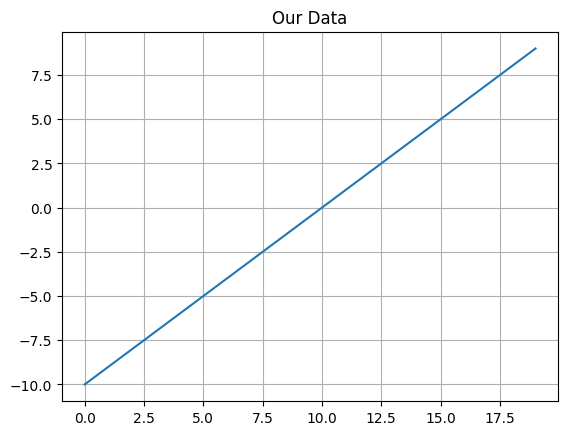

In [66]:
# Visualize our plot
plt.plot(A);
plt.title('Our Data')
plt.grid()

In [67]:
def relu(x:torch.Tensor) -> torch.Tensor:
  return torch.max(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

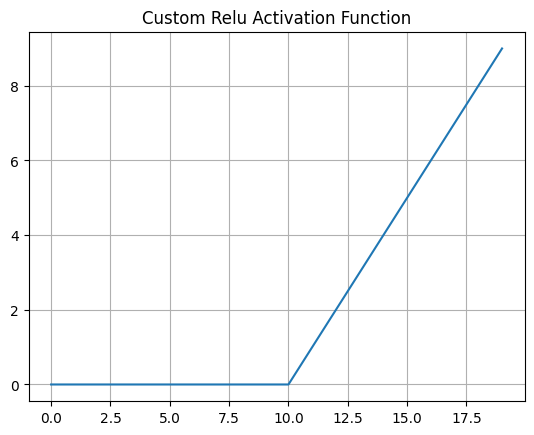

In [68]:
plt.plot(relu(A))
plt.title('Custom Relu Activation Function')
plt.grid()

In [69]:
def sigmoid(x:torch.tensor) -> torch.tensor:
  return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

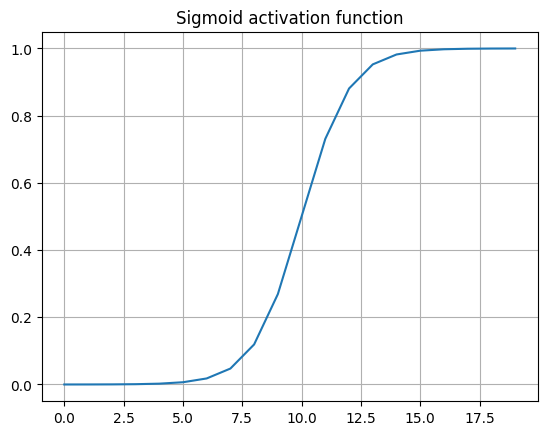

In [70]:
plt.plot(sigmoid(A))
plt.title('Sigmoid activation function')
plt.grid()

# Multi-Class classification (Putting it all together)

* Now we are going to build a Non-linear powered PyTorch model on a Multi-classification data, while also revising all the steps, in Project Workflow of a Classification problem

## Creating a Toy multi-class classification dataset

In [71]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# set hyperparameters for Data Generation
NUM_SAMPLES=1000
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# generate data
X_blob, y_blob = make_blobs(
    n_samples=NUM_SAMPLES,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std = 1.5,
    random_state=RANDOM_SEED
)

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# Splitting into Training and testing
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED
)

X_blob_train.shape, y_blob_train.shape, X_blob_test.shape, y_blob_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

In [72]:
X_blob_train[:5], y_blob_train[:5]

(tensor([[ 5.0405,  3.3076],
         [-2.6249,  9.5260],
         [-8.5240, -9.0402],
         [-6.0262, -4.4375],
         [-3.3397,  7.2175]]),
 tensor([1., 0., 2., 2., 0.]))

### Plotting our data

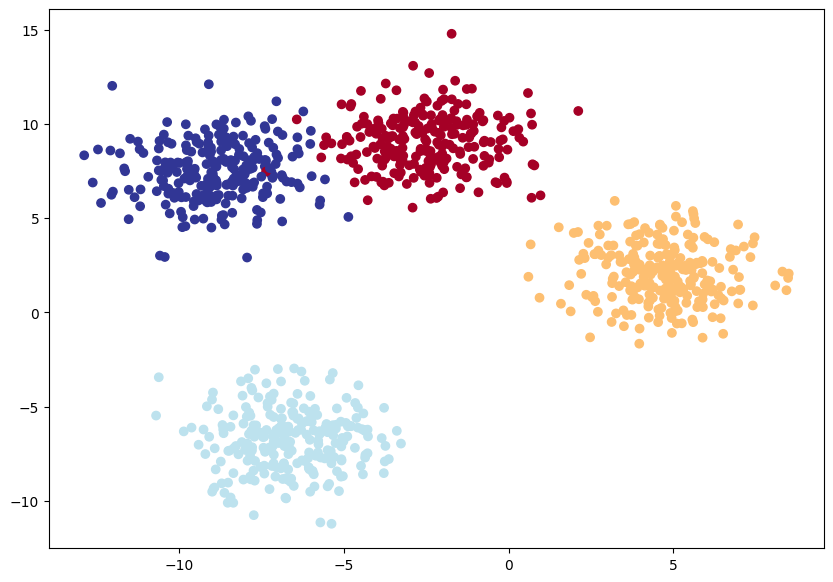

In [73]:
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

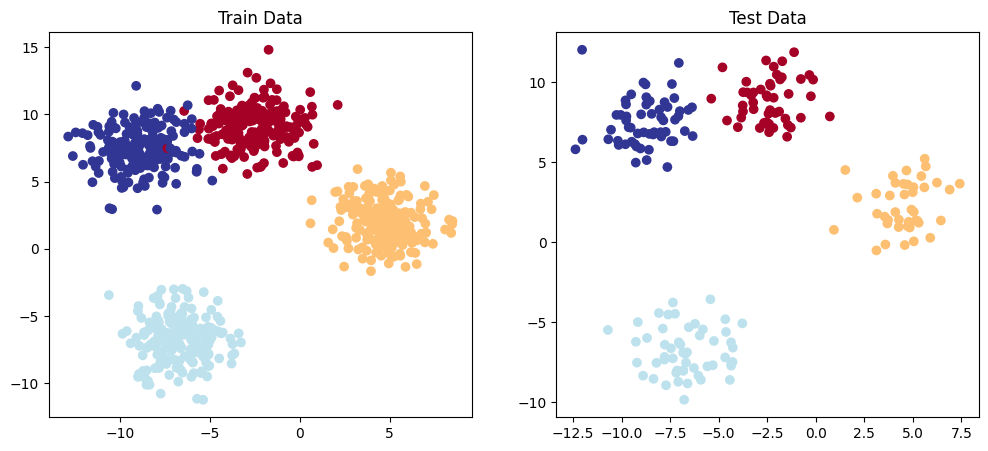

In [74]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Train Data')
plt.scatter(X_blob_train[:, 0], X_blob_train[:, 1], c=y_blob_train, cmap=plt.cm.RdYlBu)
plt.subplot(1, 2, 2)
plt.title('Test Data')
plt.scatter(X_blob_test[:, 0], X_blob_test[:, 1], c=y_blob_test, cmap=plt.cm.RdYlBu)

## Creating a Multi-classification Non-linear powered PyTorch Model

In [75]:
# Set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [76]:
class BlobModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # create a stack of linear layers along with non-linear activations
    self.linear_stack = nn.Sequential(
        nn.Linear(in_features=2, out_features=32),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=8),
        nn.ReLU(),
        nn.Linear(in_features=8, out_features=4)
    )

  def forward(self, X:torch.tensor) -> torch.tensor:
    return self.linear_stack(X)

blob_model = BlobModelV0().to(device)
blob_model

BlobModelV0(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [77]:
next(blob_model.parameters()).device

device(type='cuda', index=0)

In [78]:
# Intializing a loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=blob_model.parameters(),
                        lr=0.1)

### Logits -> Probabilities -> Predictions

Getting prediction from our Multi-class PyTorch model

In [79]:
with torch.inference_mode():
  untrained_logits = blob_model(X_blob_test.to(device))
untrained_logits[:10]

tensor([[-0.4366, -0.0324,  0.2011,  0.0473],
        [-0.2625, -0.1560,  0.1425,  0.1213],
        [-0.2104, -0.0300,  0.2139,  0.0263],
        [-0.3012, -0.0052,  0.1681, -0.0247],
        [-0.3361, -0.1718,  0.2151,  0.2643],
        [-0.2723, -0.1598,  0.1502,  0.1297],
        [-0.1554, -0.0118,  0.2744,  0.0500],
        [-0.3129, -0.1764,  0.1902,  0.1926],
        [-0.2327, -0.0181,  0.2153,  0.0040],
        [-0.3151, -0.1759,  0.1953,  0.2144]], device='cuda:0')

In [80]:
untrained_logits.shape

torch.Size([200, 4])

In [81]:
y_blob_test[:10]

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0.])

Now, we will go from logits to probabilities using our `softmax activation function`

In [82]:
untrained_probabilites = torch.softmax(untrained_logits, dim=1)
untrained_probabilites[:5], untrained_probabilites.shape

(tensor([[0.1663, 0.2492, 0.3147, 0.2698],
         [0.1969, 0.2190, 0.2952, 0.2890],
         [0.2003, 0.2399, 0.3061, 0.2537],
         [0.1901, 0.2555, 0.3039, 0.2506],
         [0.1743, 0.2054, 0.3025, 0.3177]], device='cuda:0'),
 torch.Size([200, 4]))

Now, we will go from probabilties to Predictions (classes)

In [83]:
untrained_preds = torch.argmax(untrained_probabilites, dim=1)
untrained_preds[:10]

tensor([2, 2, 2, 2, 3, 2, 2, 3, 2, 3], device='cuda:0')

In [84]:
y_blob_test[:10]

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0.])

## Creating a Training & Testing Loop

In [85]:
EPOCHS = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(EPOCHS):
  blob_model.train()

  y_logits = blob_model(X_blob_train)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

  train_loss = loss_fn(y_logits, y_blob_train.long())
  train_acc = accuracy_fn(y_blob_train, y_preds)

  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  blob_model.eval()
  with torch.inference_mode():
    test_logits = blob_model(X_blob_test)
    test_preds = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)

    test_loss = loss_fn(test_logits, y_blob_test.long())
    test_acc = accuracy_fn(y_blob_test, test_preds)

  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}')

Epoch: 0 | Train Loss: 1.37515 | Train Accuracy: 24.62 | Test Loss: 1.33464 | Test Accuracy: 27.50
Epoch: 10 | Train Loss: 1.01501 | Train Accuracy: 71.38 | Test Loss: 0.97153 | Test Accuracy: 74.00
Epoch: 20 | Train Loss: 0.64302 | Train Accuracy: 89.62 | Test Loss: 0.62589 | Test Accuracy: 96.00
Epoch: 30 | Train Loss: 0.25411 | Train Accuracy: 98.50 | Test Loss: 0.22821 | Test Accuracy: 100.00
Epoch: 40 | Train Loss: 0.09349 | Train Accuracy: 99.00 | Test Loss: 0.08482 | Test Accuracy: 99.50
Epoch: 50 | Train Loss: 0.05828 | Train Accuracy: 99.00 | Test Loss: 0.05026 | Test Accuracy: 99.50
Epoch: 60 | Train Loss: 0.04551 | Train Accuracy: 99.00 | Test Loss: 0.03836 | Test Accuracy: 99.50
Epoch: 70 | Train Loss: 0.03957 | Train Accuracy: 99.00 | Test Loss: 0.03210 | Test Accuracy: 99.50
Epoch: 80 | Train Loss: 0.03617 | Train Accuracy: 99.00 | Test Loss: 0.02829 | Test Accuracy: 99.50
Epoch: 90 | Train Loss: 0.03401 | Train Accuracy: 99.00 | Test Loss: 0.02576 | Test Accuracy: 99.50


In [86]:
with torch.inference_mode():
  y_preds = torch.softmax(blob_model(X_blob_test), dim=1).argmax(dim=1)
y_preds[:10], y_blob_test[:10]

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'),
 tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0.], device='cuda:0'))

In [87]:
print(f'Test Accuracy: {accuracy_fn(y_preds, y_blob_test)}%')

Test Accuracy: 99.5%


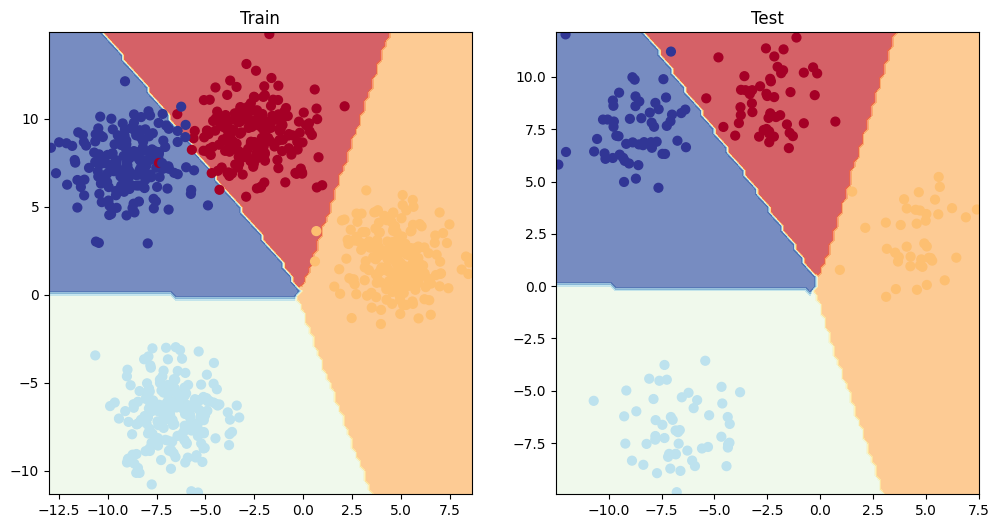

In [88]:
# plot decision boundary of model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(blob_model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(blob_model, X_blob_test, y_blob_test)

## A few more classification metrics..

* Accuracy
* Precision
* Recall
* Confusion Matrics
* Classification report

If you want an access to metrics from PyTorch, go to : `torchmetrics`

In [89]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 6.9 MB/s eta 0:00:00


In [90]:
from torchmetrics import Accuracy

# setting metric
torchmetric_acc = Accuracy(task="multiclass", num_classes=4).to(device)
# Calculating accuracy
acc = torchmetric_acc(y_preds, y_blob_test)
print(f'Accuracy: {acc}')

Accuracy: 0.9950000047683716


In [91]:
from torchmetrics import Precision

torchmetric_precision = Precision(task="multiclass", num_classes=4, average='macro').to(device)
precision = torchmetric_precision(y_preds, y_blob_test)
print(f'Precision: {precision}')

Precision: 0.9950000047683716


In [92]:
from torchmetrics import Recall

torchmetric_recall = Recall(task="multiclass", num_classes=4, average='macro').to(device)
recall = torchmetric_recall(y_preds, y_blob_test)
print(f'Recall: {recall}')

Recall: 0.9956140518188477


In [93]:
from torchmetrics import F1Score

torchmetric_f1 = F1Score(task="multiclass", num_classes=4, average='macro').to(device)
f1 = torchmetric_f1(y_preds, y_blob_test)
print(f'F1 Score: {f1}')

F1 Score: 0.9952623248100281


## Saving our Best model from Multi-class classification and Binary class Classification

In [94]:
# Saving our binary classification model's state_dict as .pt format
torch.save(model_3.state_dict(), 'binary_classification_model.pt')

# Saving our Multi-class classification model's state dict as .pt format
torch.save(blob_model.state_dict(), 'multi_classification_model.pt')